In [1]:
import numpy as np
import matplotlib.pyplot as plt, pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random, os, sys, pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [2]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

# Load Data & Signals

In [4]:
trade_date = '2022-10-03'
asset_name = 'BIDU'

In [5]:
reward_fn = f'{asset_name}_{trade_date}_rewards.pkl'
all_data  = pd.read_pickle(f'../data/Rewards/{reward_fn}')
all_data  = all_data[~all_data.index.duplicated()]

In [18]:
# all_data
# all_data.buyPrice_TF.dropna()
#all_data
import gpflow.covariances as tmpmod
tmpmod.Kuu

<dispatched Kuu>

# GP bandits

In [8]:
from AOE.utils import verbose_print
from AOE.bandit_plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots
from AOE.gp_bandit_finance import gp_bandit_finance, Wasserstein_GP_mean #, Wasserstein_GP

In [9]:
strategies  = {'imbalance_1' : {'name'             : 'imbalance_1',
                                     'params'           : {'feature_name'     : 'imbalance_1'},
                                     'contextual_params': {'feature_name'     : 'imbalance_1'}},

               'MR' : {'name'             : 'MR',
                                  'params'           : {'feature_name'     : 'MR'},
                                  'contextual_params': {'feature_name'     : 'MR'}},

               'TF' : {'name'             : 'TF',
                                  'params'           : {'feature_name'     : 'TF'},
                                  'contextual_params': {'feature_name'     : 'TF'}}
               }

In [10]:
features = all_data[[s for s in all_data.columns if (('buyPrice' not in s)&('sellPrice' not in s))]]

In [11]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer             = 30 # in terms of number of rewards to sample from
size_buffer_2           = 30 # in terms of number of rewards to sample from
size_window             = 15 # for non statonarity
bandit_params = {'size_buffer': size_buffer_2, 
                 'size_window': size_window,
                 'threshold'  : 0.0005,
                 'lambda'     : 0.1}

# Bandit objects
bandits = {'TS_NS'  : gp_bandit_finance(strategies, bandit_algo='TS_NS', likelihood=likelihood, 
                                                 bandit_params=bandit_params), 
           'UCB_NS' : gp_bandit_finance(strategies, bandit_algo='UCB_NS', likelihood=likelihood, 
                                                 bandit_params=bandit_params),
           # 'TS'  : gp_bandit_finance(strategies, bandit_algo='TS', likelihood=likelihood, size_buffer=size_buffer, size_window=size_window), 
           # 'UCB' : gp_bandit_finance(strategies, bandit_algo='UCB', likelihood=likelihood, size_buffer=size_buffer, size_window=size_window, bandit_params=0.1),
           'TS_WAS'      : gp_bandit_finance(strategies, bandit_algo='TS_WAS', likelihood=likelihood, 
                                         bandit_params=bandit_params),
           'UCB_WAS'      : gp_bandit_finance(strategies, bandit_algo='UCB_WAS', likelihood=likelihood, 
                                         bandit_params=bandit_params)}


# Other control parameters and variables

In [12]:
# variables for historical trading data
i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in bandits.keys()}
verbose_level             = 0
arrival_intensity         = 0.5
ref_price                 = 'ST'
nb_orders                 = 0

In [13]:
def init_variables(all_data, bandits):
    bandit_rewards = pd.DataFrame(index=all_data.index)
    for bandit_k in bandits.keys(): 
        bandit_rewards[bandit_k] = np.nan
    bandit_rewards['oracle'] = np.nan
    for strat in strategies.keys():
        bandit_rewards[strat] = np.nan
    
    batch_times = list(all_data.index)
    # distances   = {bandit_k:{strat: [] for strat in strategies.keys()} for bandit_k in bandits.keys()}

    bandits_fin_info = {bandit_k:pd.DataFrame(index=all_data.index) for bandit_k in bandits.keys()}
    for bandit_k in bandits.keys(): 
        bandits_fin_info[bandit_k]['execPrice'] = np.nan
        bandits_fin_info[bandit_k]['S0']        = np.nan
        bandits_fin_info[bandit_k]['ST']        = np.nan
        bandits_fin_info[bandit_k]['twapPrice'] = np.nan
        
    return bandit_rewards, bandits_fin_info, batch_times

# Trading simulation

In [14]:
def alpha(gamma, sigma, V, nu, dt):
    cosh_alpha_dt = 1 + (gamma * V * (dt*sigma)**2) / (4 * nu)
    return (1/dt) * np.arccosh(cosh_alpha_dt)

def q_star(x, q0, T, gamma, sigma, V, nu, dt):
    alpha_ = alpha(gamma, sigma, V, nu, dt)
    return q0 * np.sinh(alpha_*(T - x))/np.sinh(alpha_*T)

S0        = 100
sigma     = 5
V         = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
nu        = 0.1 # dollar per contract
gamma     = 10**1 #per dollar
T         = 3/60/24

timesteps = np.linspace(0, T, 100)
q0        = 100 #int(0.1 * V) # nb of shares to liquidate : 10% of total traded volume
dt        = T/100

In [ ]:
# bandit_rewards
# tmp_pnls

In [ ]:
# feature_values

************************************ Simul number: 0


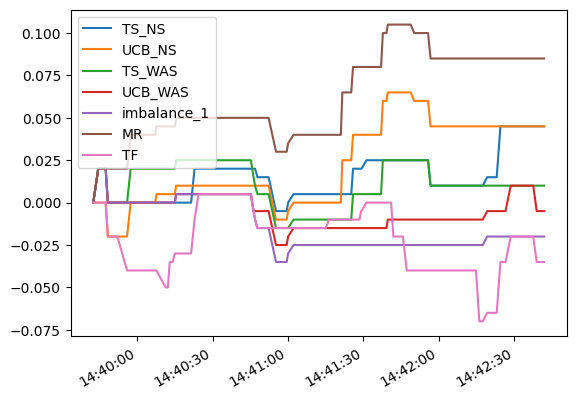

             count   mean  std  sharpe
oracle         1.0  0.245  NaN     NaN
MR             1.0  0.085  NaN     NaN
UCB_NS         1.0  0.045  NaN     NaN
TS_NS          1.0  0.045  NaN     NaN
TS_WAS         1.0  0.010  NaN     NaN
UCB_WAS        1.0 -0.005  NaN     NaN
imbalance_1    1.0 -0.020  NaN     NaN
TF             1.0 -0.035  NaN     NaN
TS_NS : 3.76 bps
UCB_NS : 3.76 bps
TS_WAS : 0.83 bps
UCB_WAS : -0.42 bps


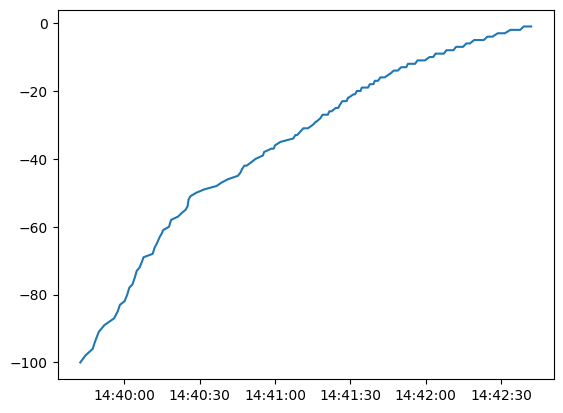

************************************ Simul number: 1


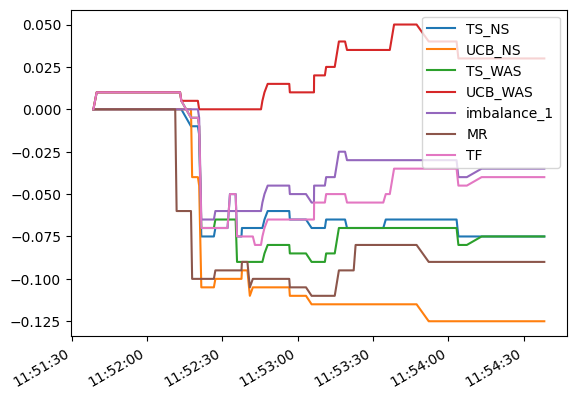

             count    mean       std     sharpe
oracle         2.0  0.1875  0.081317   2.305783
UCB_WAS        2.0  0.0125  0.024749   0.505076
MR             2.0 -0.0025  0.123744  -0.020203
TS_NS          2.0 -0.0150  0.084853  -0.176777
imbalance_1    2.0 -0.0275  0.010607  -2.592725
TS_WAS         2.0 -0.0325  0.060104  -0.540729
TF             2.0 -0.0375  0.003536 -10.606602
UCB_NS         2.0 -0.0400  0.120208  -0.332756
TS_NS : -1.26 bps
UCB_NS : -3.37 bps
TS_WAS : -2.74 bps
UCB_WAS : 1.05 bps


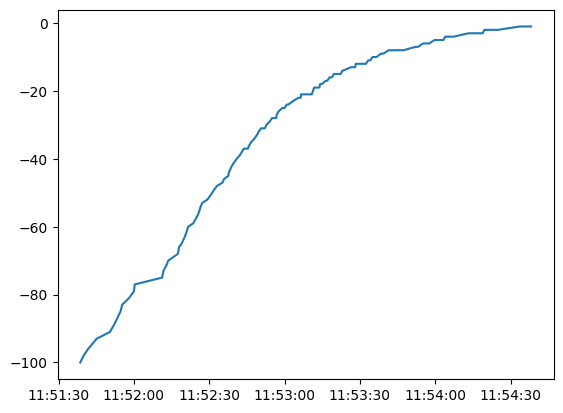

************************************ Simul number: 2


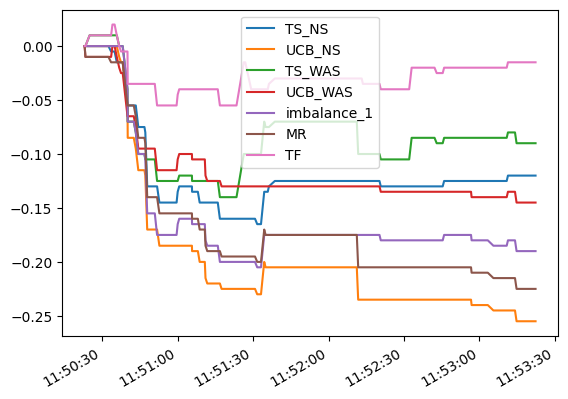

             count      mean       std    sharpe
oracle         3.0  0.173333  0.062517  2.772594
TF             3.0 -0.030000  0.013229 -2.267787
UCB_WAS        3.0 -0.040000  0.092601 -0.431959
TS_NS          3.0 -0.050000  0.085294 -0.586210
TS_WAS         3.0 -0.051667  0.053929 -0.958050
MR             3.0 -0.076667  0.155430 -0.493257
imbalance_1    3.0 -0.081667  0.094119 -0.867698
UCB_NS         3.0 -0.111667  0.150444 -0.742248
TS_NS : -4.21 bps
UCB_NS : -9.4 bps
TS_WAS : -4.35 bps
UCB_WAS : -3.37 bps


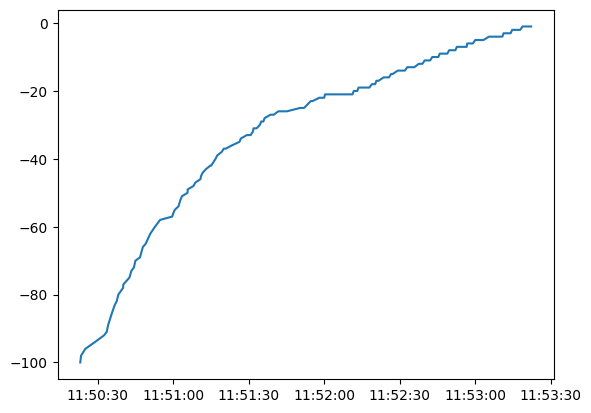

************************************ Simul number: 3


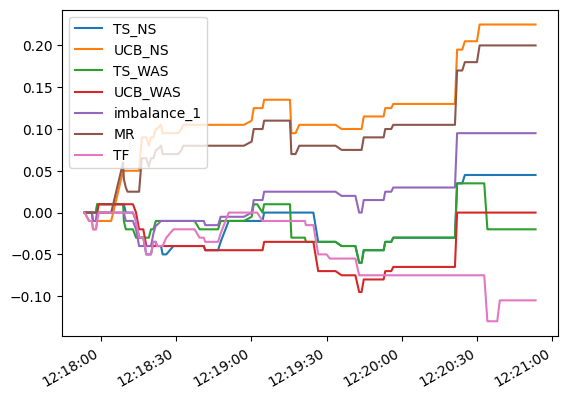

             count     mean       std    sharpe
oracle         4.0  0.23375  0.131173  1.782003
MR             4.0 -0.00750  0.187728 -0.039951
TS_NS          4.0 -0.02625  0.084299 -0.311393
UCB_NS         4.0 -0.02750  0.208387 -0.131966
UCB_WAS        4.0 -0.03000  0.078209 -0.383587
imbalance_1    4.0 -0.03750  0.117083 -0.320287
TS_WAS         4.0 -0.04375  0.046793 -0.934969
TF             4.0 -0.04875  0.039025 -1.249213
TS_NS : -2.21 bps
UCB_NS : -2.31 bps
TS_WAS : -3.68 bps
UCB_WAS : -2.52 bps


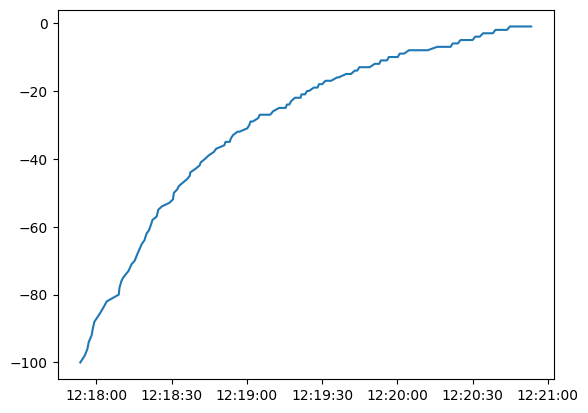

************************************ Simul number: 4


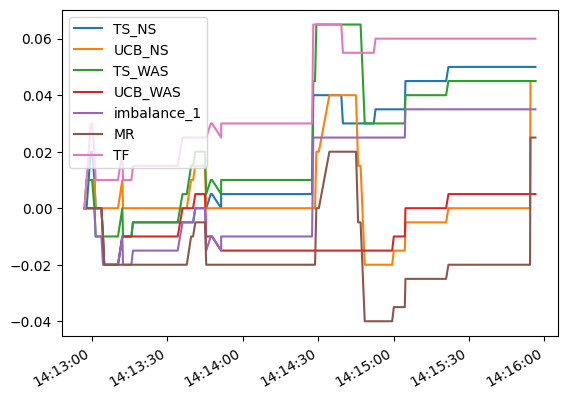

             count   mean       std    sharpe
oracle         5.0  0.232  0.113666  2.041064
MR             5.0 -0.001  0.163225 -0.006127
TS_NS          5.0 -0.011  0.080576 -0.136517
UCB_NS         5.0 -0.013  0.183358 -0.070900
imbalance_1    5.0 -0.023  0.106454 -0.216055
UCB_WAS        5.0 -0.023  0.069516 -0.330858
TS_WAS         5.0 -0.026  0.056723 -0.458368
TF             5.0 -0.027  0.059224 -0.455895
TS_NS : -0.92 bps
UCB_NS : -1.08 bps
TS_WAS : -2.17 bps
UCB_WAS : -1.92 bps


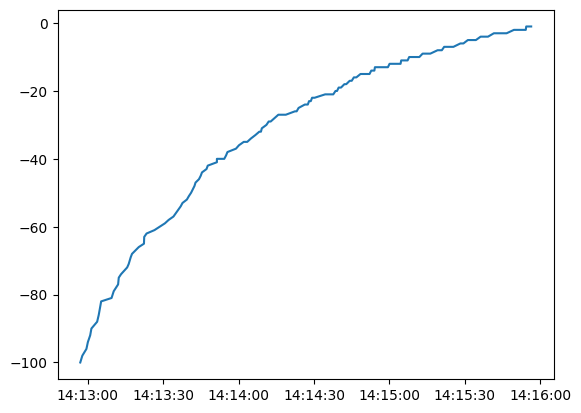

************************************ Simul number: 5


KeyboardInterrupt: 

In [15]:
nb_simulations    = 200
res_simulations   = {}
programme_horizon = '10min'

for i_simul in range(nb_simulations):
    print('************************************ Simul number:', i_simul)
    
    # choose a random starting point for the programme starting time
    i_start = int(np.random.rand(1)*(9*len(all_data)/10))
    programme_data = all_data.iloc[i_start:].first(programme_horizon)
    
    # Fill na exec prices accordingly
    for col in programme_data.columns:
        if 'Price_' in col:
            programme_data[col].fillna(programme_data[ref_price], inplace=True)

    bandit_rewards, bandits_fin_info, batch_times = init_variables(programme_data, bandits)
    
    buysell          = 2*np.random.randint(0, 2, size=None, dtype=int)-1
    verbose_print(verbose_level, None, f'I received an order at {None} with quantity {buysell}', True)
    
    q0     = 100*buysell
    q      = np.zeros(len(batch_times)+1)
    q[0]   = q0
    dt     = T/len(batch_times)
    
    for (i_time, batch_time) in enumerate(batch_times): # leave a few minutes
        # if np.random.poisson(arrival_intensity)>0:
        sigma       = 5
        q_cible     = q_star(T * i_time/len(batch_times), q0, T, 10**-3, sigma, V, nu, dt)
        trade_size  = int(q_cible - q[i_time])     
        q[i_time+1] = q[i_time]+trade_size
        
        V           = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
        nu          = 0.1
        nb_orders   += 1
        
#             if ((nb_orders%20==0) & (i_time>0)):
#                 print('************************************ Simul number:', i_simul)
#                 clear_output(wait=True)
#                 verbose_level = 1
#                 for bandit_k in bandits.keys():
#                     bandits[bandit_k].plot_strategies()         

#                 # get historical rewards and regret
#                 rewards_to_plot = pd.DataFrame(index=programme_data.index)
#                 for bandit_k in bandits.keys():
#                     rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
#                 for (i_strat, strat) in enumerate(strategies.keys()):
#                     rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
#                 rewards_to_plot = rewards_to_plot.sort_index()
#                 regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)
#             else:
#                 verbose_level = 0

        trade_date = str(batch_time).split(' ')[0]

        ###############################################
        # retrain GPs hyperparameters every N orders 
        ###############################################
        retrain_hyperparameters = True

        ##################################################
        # if an order arrives: decide if buy & sell
        ##################################################
        i_order          += 1

        ######################
        # get feature values
        ######################
        feature_values = features.loc[batch_time, :]

        ######################################
        # select the strategy for all bandits
        ######################################
        verbose_print(verbose_level, batch_time, f'Selecting strategies ...')
        best_strategies_bandits = {}
        for bandit_k in bandits.keys():
            verbose_print(verbose_level, batch_time, f'** Bandit {bandit_k}: Selecting strategies ...')
            if i_time < 5*len(strategies): # at least 5 rewards before sampling
                best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
            else:
                best_strategies_bandits[bandit_k]  = bandits[bandit_k].select_best_strategy(feature_values)
            verbose_print(verbose_level, batch_time, f'Selected strategy: {best_strategies_bandits[bandit_k]}')

        ######################################
        # Update & Retrain the GPs
        # & Non stationarity test
        ######################################
        tmp_pnls = {bandit_k:np.nan for bandit_k in bandits.keys()}
        for bandit_k in bandits.keys():
            if buysell == 1:
                tmp_pnls[bandit_k] = -programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                tmp_pnls[bandit_k] = programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] - \
                            programme_data.loc[batch_time, ref_price]

        for bandit_k in bandits.keys():
            # print('Adding: ', feature_values, best_strategies_bandits[bandit_k], tmp_pnls[bandit_k])
            bandits[bandit_k].update_data(features  = feature_values, 
                                          strat     = best_strategies_bandits[bandit_k], 
                                          reward    = tmp_pnls[bandit_k],
                                          retrain_hyperparameters = retrain_hyperparameters)

        ######################################
        # Record rewards
        ######################################
        for bandit_k in bandits.keys():
            if buysell == 1:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] 
            else:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] 

            bandit_rewards.loc[batch_time, bandit_k]               = tmp_pnls[bandit_k]
            bandits_fin_info[bandit_k].loc[batch_time,'S0']        = programme_data.loc[batch_time, 'S0'] 
            bandits_fin_info[bandit_k].loc[batch_time,'ST']        = programme_data.loc[batch_time, 'ST'] 
            bandits_fin_info[bandit_k].loc[batch_time,'twapPrice'] = programme_data.loc[batch_time, 'twapPrice'] 

        for strat in strategies.keys():
            if buysell == 1:
                bandit_rewards.loc[batch_time, strat] = \
                            -programme_data.loc[batch_time, f'buyPrice_{strat}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                bandit_rewards.loc[batch_time, strat] = \
                            programme_data.loc[batch_time, f'sellPrice_{strat}'] - \
                            programme_data.loc[batch_time, ref_price]


        ##############################
        # Record oracle info
        ##############################
        oracle_strategy = bandit_rewards.loc[batch_time, strategies.keys()].idxmax() #(pnls_buy.loc[batch_time]).idxmax()
        bandit_rewards.loc[batch_time, 'oracle'] = bandit_rewards.loc[batch_time, f'{oracle_strategy}']
        verbose_print(verbose_level, batch_time, f"Oracle strategy: {oracle_strategy}")
    
    # multiply pnls by trading speed
    v = np.diff(q)
    for i in range(len(bandit_rewards)):
        bandit_rewards.iloc[i,:] = np.abs(v[i]) * bandit_rewards.iloc[i,:]

    res_simulations[i_simul] = buysell, bandit_rewards, bandits_fin_info, q
    
    # see regrets & rewards
    rewards_to_plot = pd.DataFrame(index=programme_data.index)
    for bandit_k in bandits.keys():
        rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
    for (i_strat, strat) in enumerate(strategies.keys()):
        rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
    rewards_to_plot = rewards_to_plot.sort_index()
    rewards_to_plot.dropna().cumsum().plot()
    plt.show()
    
    df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
    stats_sim = df_sim_results.describe().T
    stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
    
    # Some printing
    print(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])
    for bandit_k in bandits.keys():
        print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )
    plt.plot(res_simulations[i_simul][1].dropna().index, q[1:]) #np.linspace(len(res_simulations[i_simul][1].dropna()), 0, len(res_simulations[i_simul][1].dropna()))
    plt.show()
    # regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)

In [ ]:
for bandit_k in bandits.keys():
    print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )

In [ ]:
# rewards_to_plot

In [ ]:
# programme_data

In [ ]:
# plt.plot(res_simulations[i_simul][1].dropna().index, q[1:])

In [ ]:
df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
print(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])

In [ ]:
# res_simulations[i][2][bandit_k]
# df_sim_results
# df_sim_results

In [ ]:
df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']

stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']]

In [ ]:
# res_simulations[i][2][bandit_k].dropna()

In [ ]:
# rewards_to_plot.dropna().cumsum().plot()

In [ ]:
# i=0
# res_simulations[i][1][bandit_k].dropna()
res_simulations[i][1][bandit_k]

In [ ]:
bench    = 'twapPrice'

for bandit_k in bandits.keys():
    print('\n', '***********', bandit_k, '***********')
    pnl_bandit = 0
    pnl_twap   = 0
    pnl_execS0 = 0
    pnl_execST = 0
    n          = len(res_simulations)
    
    for i in range(n):
        tmp_bandit   = res_simulations[i][2][bandit_k].dropna()
        pnl_bandit   += tmp_bandit.execPrice.sum() - tmp_bandit[bench].sum()
        # pnl_twap     += tmp_bandit.twapPrice.sum() - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
        # pnl_execS0   += tmp_bandit.S0.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
        # pnl_execST   += tmp_bandit.ST.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]

    print('PNL:', pnl_bandit/n)
# res_simulations[i][1]['TS_WAS'].dropna().S0.sum()

In [ ]:
# fig, axes = plt.subplots(2, 3, sharey=True)
# for (i_i, bandit_k) in enumerate(bandits.keys()):
#     for (i_j, strat) in enumerate(strategies):
#         axes[i_i, i_j].plot(distances[bandit_k][strat])
#         axes[i_i, i_j].set_title(f'bandit {bandit_k}\n strat {strat}')
#         axes[i_i, i_j].grid(axis='both')
# plt.tight_layout()

# Regret analysis

In [ ]:
# get historical rewards and regret
rewards_to_plot = pd.DataFrame(index=all_data.index)
regrets_to_plot = pd.DataFrame(index=all_data.index)

for bandit_k in bandits.keys():
    regrets_to_plot[bandit_k] = - np.array(bandit_rewards[bandit_k]) + np.array(bandit_rewards['oracle'])
for (i_strat, strat) in enumerate(strategies.keys()):
    regrets_to_plot[strat]    = - np.array(bandit_rewards[strat]) + np.array(bandit_rewards['oracle'])

for bandit_k in bandits.keys():
    rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
for (i_strat, strat) in enumerate(strategies.keys()):
    rewards_to_plot[strat]    = np.array(bandit_rewards[strat])

regrets_to_plot = regrets_to_plot.sort_index()
rewards_to_plot = rewards_to_plot.sort_index()

### Hit ratio

In [ ]:
# (bandit_rewards.dropna()['UCB']==bandit_rewards.dropna()['oracle']).sum()/len(bandit_rewards.dropna())

In [ ]:
hit_ratio_analysis(rewards_to_plot, bandit_rewards['oracle'], bandits, _W = 5.5)

### Reward distributions

In [ ]:
for (clr, bandit_k) in zip(('k', 'tan', 'blue'), bandits.keys()):
    rewards_to_plot[bandit_k].hist(bins=30,  color=clr, alpha=0.4, density=True)

plt.legend(bandits.keys())

### Reward distributions in time

In [ ]:
period_est  = 20 # in number of rewards, can be "10min"
bandit_name = 'TS_WAS'

reward_distribution_analysis(bandit_name, bandits, period_est, all_data, rewards_to_plot.dropna(), bandit_rewards.dropna(),
                              strategies, W = 7, figure_name = None)

### Regret plots

In [ ]:
regret_plots(strategies, regrets_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

In [ ]:
regret_plots(strategies, rewards_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

### GP plot

In [ ]:
bandit_name  = 'TS_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
bandit_name  = 'UCB_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
rewards_to_plot